🅰️ A. Problem Definition
Objective:
Build models that detect fraudulent credit card transactions based on anonymized features.

Type:

Binary Classification problem (Fraud = 1, Genuine = 0).

Highly Imbalanced → special care needed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler ,RobustScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.metrics import classification_report_imbalanced

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

🅱️ B. Data Collection
Load Dataset:

Read CSV into a pandas DataFrame.

Inspect Data:

Size of dataset (number of rows, columns).

Check for missing values (although unlikely in this dataset).

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
pd.options.display.max_columns = None

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.shape

(284807, 31)

In [7]:
print("Number of Rows",df.shape[0])
print("Number of Columns",df.shape[1])

Number of Rows 284807
Number of Columns 31


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
df.duplicated().any()

np.True_

In [12]:
df = df.drop_duplicates()

In [13]:
df.shape

(283726, 31)

In [14]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [15]:
# Print class distribution
print('No Frauds:', round(df['Class'].value_counts()[0] / len(df) * 100, 2), '%')
print('Frauds:', round(df['Class'].value_counts()[1] / len(df) * 100, 2), '%')

No Frauds: 99.83 %
Frauds: 0.17 %


In [16]:
# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

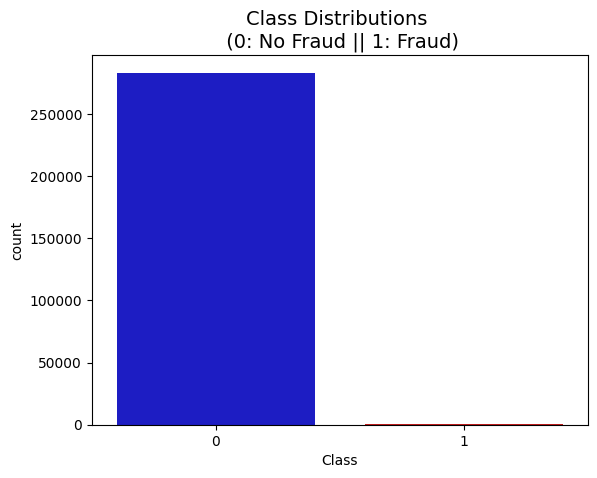

In [17]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()


In [18]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [19]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.478654,-0.182124,1.054379,-0.764756,0.160168,0.665587,1.113466,4.771656,-1.536609,1.306483,1.565054,-0.349941,-1.238496,0.608002,-0.249115,-0.933969,-1.407873,-0.191383,-0.180853,0.226980,0.537470,0.050995,-0.097138,-0.029759,-0.171596,1.047201,0.698595,-0.217939,0.101970,0.040152,0
1,-0.169378,-0.046108,-4.805134,4.351191,-0.916135,-0.900752,-0.870777,-0.782946,0.328104,0.582501,2.749336,4.728060,0.455162,0.649740,0.930379,-1.663325,1.334738,-0.283321,0.152340,-0.950771,-0.935567,2.160193,-0.854486,-0.758266,0.147005,-0.021274,0.552660,0.008318,0.431835,-0.436239,0
2,0.334863,-0.511327,-1.549833,-0.261143,1.556289,-2.037817,-0.366315,-1.334314,0.165406,-0.025782,-1.472751,-0.172838,-0.594842,0.063059,1.054185,-0.171535,0.192041,-0.867483,-0.348274,0.743352,-1.454672,-0.347365,-0.405656,-0.951005,-0.147752,0.424100,0.081845,1.103559,-0.502271,-0.248822,0
3,-0.256154,-0.987464,0.216344,0.663182,1.303520,0.169219,-0.404266,-0.517288,-0.036938,-0.838221,-0.528675,-0.174777,1.648466,1.114947,0.202150,0.479424,0.226420,0.456003,-0.558258,-0.101939,0.000758,-0.184929,0.552788,-0.961206,-0.014642,0.525962,0.750877,0.141543,0.045107,0.127321,0
4,-0.266444,0.895224,-0.273365,0.825649,0.555674,0.384915,1.343842,1.984159,0.321808,0.510275,-0.891463,-0.115561,0.952916,-0.221254,-0.867646,0.974855,2.441035,-1.711023,0.902400,0.022272,2.097232,0.172188,0.346482,1.162889,-0.557535,-0.896146,0.503553,0.555129,0.129099,0.047571,0


In [20]:
def remove_outliers(df, feature, label_col='Class'):
    fraud_values = df[feature][df[label_col] == 1].values
    q25, q75 = np.percentile(fraud_values, 25), np.percentile(fraud_values, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    df = df[(df[feature] >= lower) & (df[feature] <= upper)]
    return df

In [21]:
for feature in ['V14', 'V12', 'V10']:
    df = remove_outliers(df, feature)

print(f"Number of instances after outlier removal: {len(df)}")

Number of instances after outlier removal: 281650


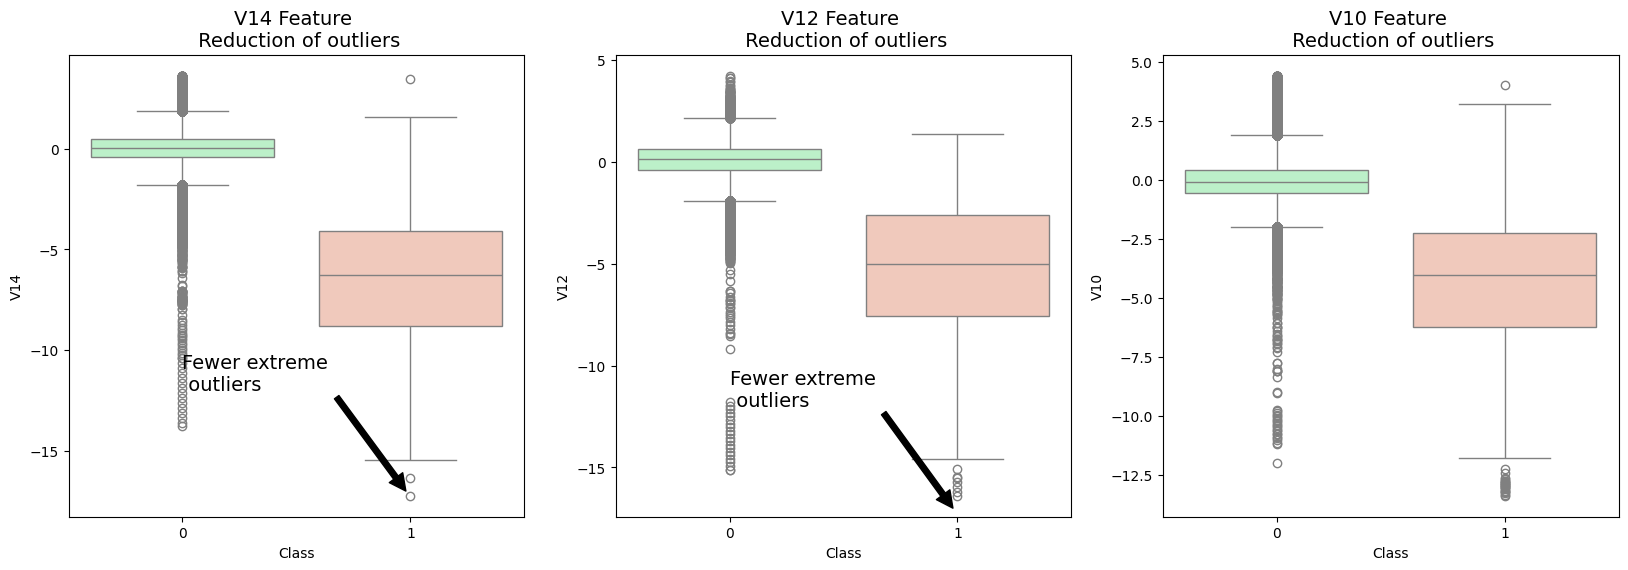

In [22]:
# Boxplot visualization of features
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
colors = ['#B3F9C5', '#f9c5b3']
for ax, feature in zip([ax1, ax2, ax3], ['V14', 'V12', 'V10']):
    sns.boxplot(x="Class", y=feature, data=df, ax=ax, palette=colors)
    ax.set_title(f"{feature} Feature \n Reduction of outliers", fontsize=14)
    ax.annotate('Fewer extreme \n outliers', xy=(0.98, -17), xytext=(0, -12),
                arrowprops=dict(facecolor='black'), fontsize=14)

plt.show()

In [23]:
X = df.drop('Class',axis=1)
y = df['Class']

In [24]:
X.shape

(281650, 30)

In [25]:
y.shape

(281650,)

In [26]:
from imblearn.over_sampling import SMOTE

In [27]:
X_res,y_res = SMOTE().fit_resample(X,y)

In [28]:
y_res.value_counts()

Class
0    281220
1    281220
Name: count, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.20,
                                                 random_state=42)

Methods ## models

In [31]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [32]:

# Store results
bagging_results = {}

In [33]:
start_rf = time.time()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]
end_rf = time.time()

In [ ]:
# --- Bagged Decision Trees ---
start_bag = time.time()
bag = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=15), n_estimators=50, random_state=42)
bag.fit(X_train, y_train)
bag_pred = bag.predict(X_test)
bag_prob = bag.predict_proba(X_test)[:, 1]
end_bag = time.time()


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56305
           1       1.00      1.00      1.00     56183

    accuracy                           1.00    112488
   macro avg       1.00      1.00      1.00    112488
weighted avg       1.00      1.00      1.00    112488

ROC AUC: 0.9999801024777007
Training + Prediction Time: 522.04 seconds


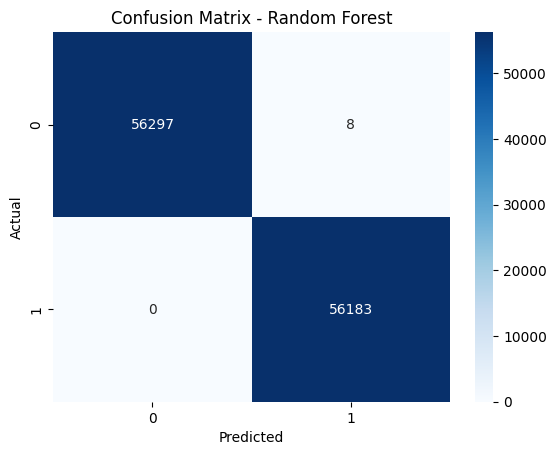


=== Bagged Trees ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56305
           1       1.00      1.00      1.00     56183

    accuracy                           1.00    112488
   macro avg       1.00      1.00      1.00    112488
weighted avg       1.00      1.00      1.00    112488

ROC AUC: 0.9998997630327068
Training + Prediction Time: 1415.33 seconds


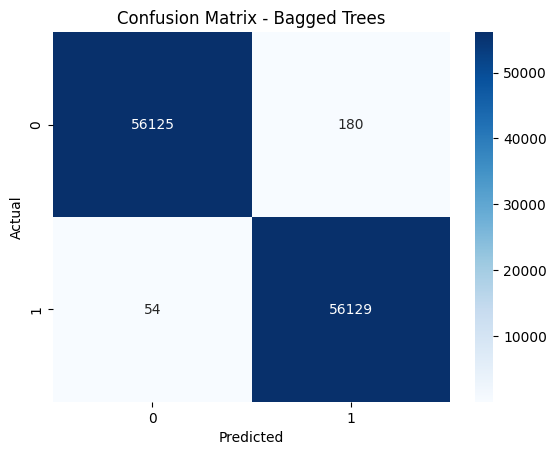

In [35]:
# --- Evaluate and Display ---
for name, pred, prob, duration in [
    ('Random Forest', rf_pred, rf_prob, end_rf - start_rf),
    ('Bagged Trees', bag_pred, bag_prob, end_bag - start_bag)
]:
    print(f"\n=== {name} ===")
    print(classification_report(y_test, pred))
    print("ROC AUC:", roc_auc_score(y_test, prob))
    print(f"Training + Prediction Time: {duration:.2f} seconds")

    # Save results
    bagging_results[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1 Score': f1_score(y_test, pred),
        'ROC AUC': roc_auc_score(y_test, prob),
        'Time (s)': duration
    }
        # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [36]:
# Convert results to DataFrame
bagging_df = pd.DataFrame(bagging_results).T
display(bagging_df)

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Time (s)
Random Forest,0.999929,0.999858,1.000000,0.999929,0.99998,522.042681
Bagged Trees,0.997920,0.996803,0.999039,0.997920,0.99990,1415.333566


In [37]:
# Store results in a dictionary
bagging_results = {
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, rf_pred),
        'Precision': precision_score(y_test, rf_pred),
        'Recall': recall_score(y_test, rf_pred),
        'F1 Score': f1_score(y_test, rf_pred),
        'ROC AUC': roc_auc_score(y_test, rf_prob),
        'Time (s)': start_rf
    },
    'Bagging': {
        'Accuracy': accuracy_score(y_test, bag_pred),
        'Precision': precision_score(y_test, bag_pred),
        'Recall': recall_score(y_test, bag_pred),
        'F1 Score': f1_score(y_test, bag_pred),
        'ROC AUC': roc_auc_score(y_test, bag_prob),
        'Time (s)': start_bag
    }
}

In [38]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [39]:
# Dictionary to store performance
boosting_results = {}

print("\nAll of these models are Boosting-based Ensemble Methods:\n"
      "- AdaBoost\n- Gradient Boosting\n- XGBoost\n")



All of these models are Boosting-based Ensemble Methods:
- AdaBoost
- Gradient Boosting
- XGBoost



In [41]:
# --- Gradient Boosting ---
start_gb = time.time()
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_prob = gb.predict_proba(X_test)[:, 1]
end_gb = time.time()

In [42]:

# --- XGBoost ---
start_xgb = time.time()
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, random_state=42)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]
end_xgb = time.time()


=== AdaBoost ===
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     56305
           1       0.97      0.93      0.95     56183

    accuracy                           0.95    112488
   macro avg       0.95      0.95      0.95    112488
weighted avg       0.95      0.95      0.95    112488

ROC AUC: 0.9933095317426728
Training + Prediction Time: 370.97 seconds


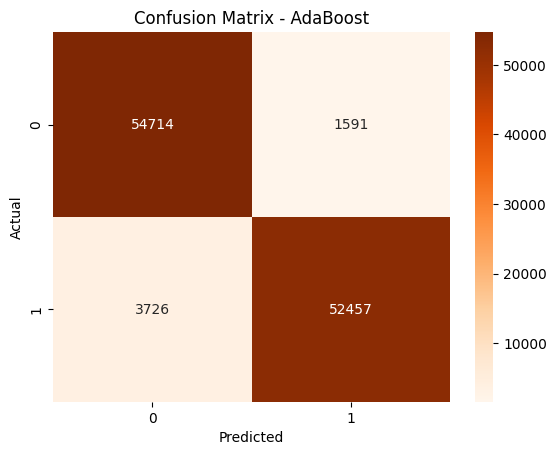


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56305
           1       0.99      0.97      0.98     56183

    accuracy                           0.98    112488
   macro avg       0.98      0.98      0.98    112488
weighted avg       0.98      0.98      0.98    112488

ROC AUC: 0.9982670403528002
Training + Prediction Time: 1033.32 seconds


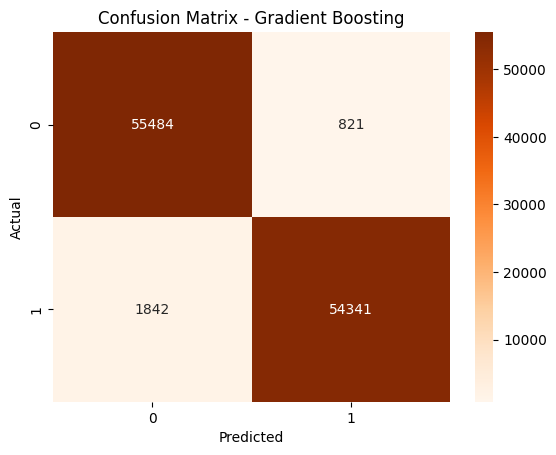


=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56305
           1       1.00      1.00      1.00     56183

    accuracy                           1.00    112488
   macro avg       1.00      1.00      1.00    112488
weighted avg       1.00      1.00      1.00    112488

ROC AUC: 0.999983141944475
Training + Prediction Time: 4.66 seconds


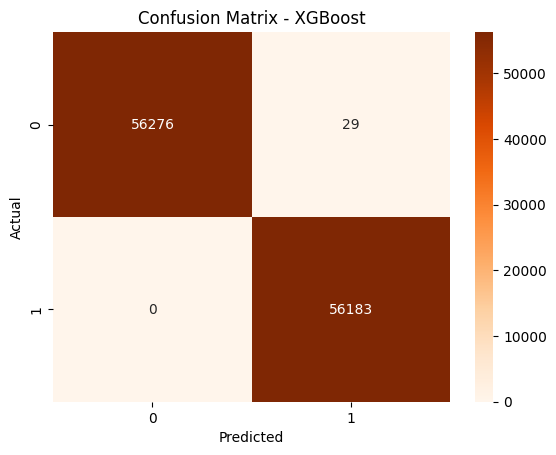

In [43]:
# --- Evaluate Boosting Models ---
for name, pred, prob, duration in [
    ('AdaBoost', ada_pred, ada_prob, end_ada - start_ada),
    ('Gradient Boosting', gb_pred, gb_prob, end_gb - start_gb),
    ('XGBoost', xgb_pred, xgb_prob, end_xgb - start_xgb)
]:
    print(f"\n=== {name} ===")
    print(classification_report(y_test, pred))
    print("ROC AUC:", roc_auc_score(y_test, prob))
    print(f"Training + Prediction Time: {duration:.2f} seconds")

    # Save metrics
    boosting_results[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1 Score': f1_score(y_test, pred),
        'ROC AUC': roc_auc_score(y_test, prob),
        'Time (s)': duration
    }

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Oranges')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [44]:
# --- Summary Table ---
boosting_df = pd.DataFrame(boosting_results).T
display(boosting_df)

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Time (s)
AdaBoost,0.952733,0.970563,0.933681,0.951765,0.993310,370.973738
Gradient Boosting,0.976326,0.985117,0.967214,0.976083,0.998267,1033.323913
XGBoost,0.999742,0.999484,1.000000,0.999742,0.999983,4.656441


In [45]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [46]:
# --- Timing Start ---
start_stack = time.time()

# --- Define and Train Stacking Model ---
stack = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=500)),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier(n_estimators=45))
    ],
    final_estimator=LogisticRegression()
)
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=500)),
                               ('dt', DecisionTreeClassifier()),
                               ('rf', RandomForestClassifier(n_estimators=45))],
                   final_estimator=LogisticRegression())

In [47]:
# --- Predict ---
stack_pred = stack.predict(X_test)
stack_prob = stack.predict_proba(X_test)[:, 1]

# --- Timing End ---
end_stack = time.time()
stack_time = end_stack - start_stack

# --- Evaluation ---
print("\n=== Stacking Method ===")
print(classification_report(y_test, stack_pred))
print("ROC AUC:", roc_auc_score(y_test, stack_prob))
print(f"Training + Prediction Time: {stack_time:.2f} seconds")


=== Stacking Method ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56305
           1       1.00      1.00      1.00     56183

    accuracy                           1.00    112488
   macro avg       1.00      1.00      1.00    112488
weighted avg       1.00      1.00      1.00    112488

ROC AUC: 0.9999769842977464
Training + Prediction Time: 1481.62 seconds


In [48]:
# --- Optional: Store metrics (for final comparison) ---
stacking_results = {
    'Accuracy': accuracy_score(y_test, stack_pred),
    'Precision': precision_score(y_test, stack_pred),
    'Recall': recall_score(y_test, stack_pred),
    'F1 Score': f1_score(y_test, stack_pred),
    'ROC AUC': roc_auc_score(y_test, stack_prob),
    'Time (s)': stack_time
}

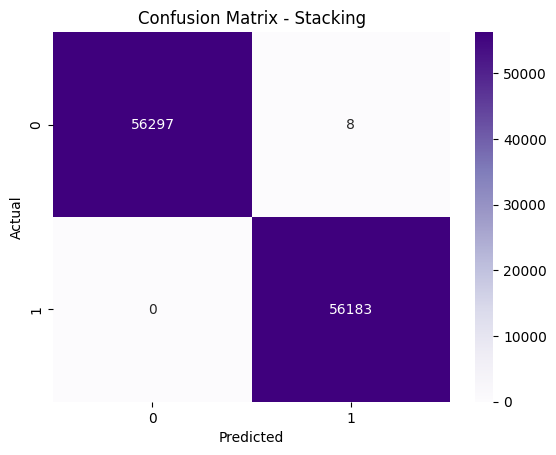

In [49]:
# --- Confusion Matrix ---
sns.heatmap(confusion_matrix(y_test, stack_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Stacking")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine results from each group
all_results = {
    'Random Forest': bagging_results['Random Forest'],
    'Bagging': bagging_results['Bagging'],
    'AdaBoost': boosting_results['AdaBoost'],
    'Gradient Boosting': boosting_results['Gradient Boosting'],
    'XGBoost': boosting_results['XGBoost'],
    'Stacking': stacking_results
}
# Create DataFrame for comparison
comparison_df = pd.DataFrame(all_results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Time (s)']] 

In [68]:
# Convert to DataFrame and reset index while keeping model names
results_df = comparison_df.reset_index().rename(columns={'index': 'Model'})
results_df = results_df.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
results_df = results_df.round(4)

In [69]:
# Print with model names
print(results_df)

               Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  \
0            XGBoost    0.9997     0.9995  1.0000    0.9997   1.0000   
1      Random Forest    0.9999     0.9999  1.0000    0.9999   1.0000   
2           Stacking    0.9999     0.9999  1.0000    0.9999   1.0000   
3            Bagging    0.9979     0.9968  0.9990    0.9979   0.9999   
4  Gradient Boosting    0.9763     0.9851  0.9672    0.9761   0.9983   
5           AdaBoost    0.9527     0.9706  0.9337    0.9518   0.9933   

       Time (s)  
0  4.656400e+00  
1  1.746133e+09  
2  1.481624e+03  
3  1.746133e+09  
4  1.033324e+03  
5  3.709737e+02  


In [72]:
# Convert time from seconds to minutes
comparison_df['Time (min)'] = comparison_df['Time (s)'] / 60

In [73]:
print(comparison_df)

                   Accuracy  Precision    Recall  F1 Score   ROC AUC  \
Random Forest      0.999929   0.999858  1.000000  0.999929  0.999980   
Bagging            0.997920   0.996803  0.999039  0.997920  0.999900   
AdaBoost           0.952733   0.970563  0.933681  0.951765  0.993310   
Gradient Boosting  0.976326   0.985117  0.967214  0.976083  0.998267   
XGBoost            0.999742   0.999484  1.000000  0.999742  0.999983   
Stacking           0.999929   0.999858  1.000000  0.999929  0.999977   

                       Time (s)    Time (min)  
Random Forest      1.746133e+09  2.910221e+07  
Bagging            1.746133e+09  2.910222e+07  
AdaBoost           3.709737e+02  6.182896e+00  
Gradient Boosting  1.033324e+03  1.722207e+01  
XGBoost            4.656441e+00  7.760736e-02  
Stacking           1.481624e+03  2.469373e+01  


Ensemble Method Comparison Table:


<Figure size 1200x700 with 0 Axes>

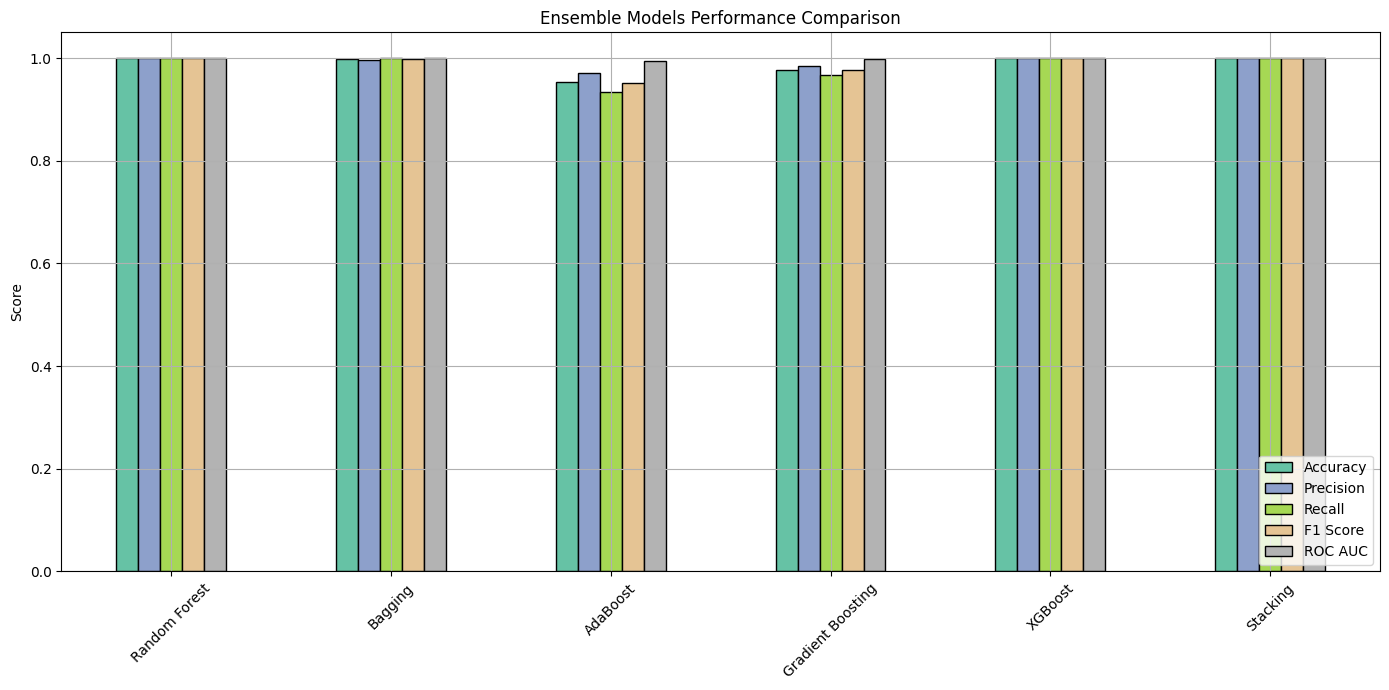

In [52]:
# Display metrics table
print("Ensemble Method Comparison Table:")
# --- Plotting Bar Charts ---
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

# 1. Metric Comparison Plot
plt.figure(figsize=(12, 7))
comparison_df[metrics_to_plot].plot(kind='bar', figsize=(14, 7), colormap='Set2', edgecolor='black')
plt.title("Ensemble Models Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

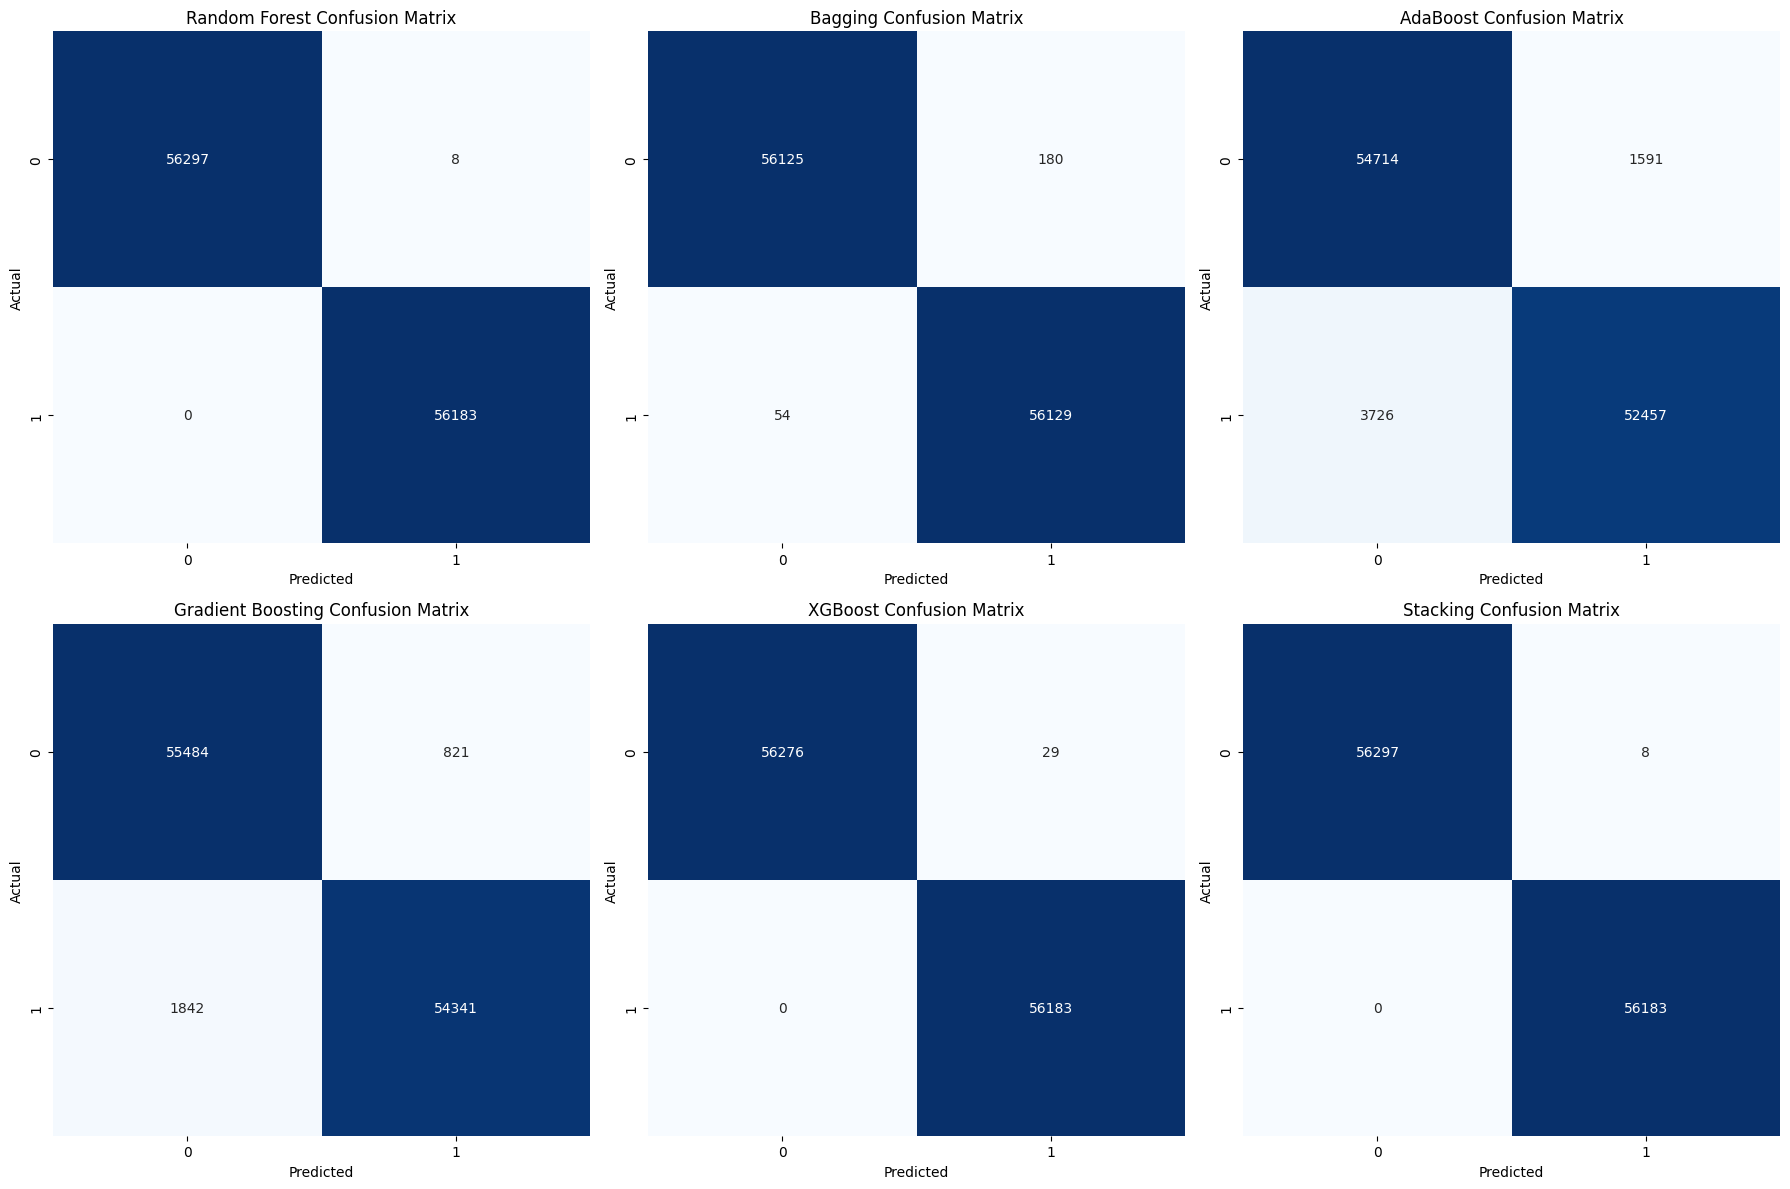

In [54]:
# Dictionary of model predictions
conf_matrices = {
    'Random Forest': confusion_matrix(y_test, rf_pred),
    'Bagging': confusion_matrix(y_test, bag_pred),
    'AdaBoost': confusion_matrix(y_test, ada_pred),
    'Gradient Boosting': confusion_matrix(y_test, gb_pred),
    'XGBoost': confusion_matrix(y_test, xgb_pred),
    'Stacking': confusion_matrix(y_test, stack_pred),
}

# Plot all confusion matrices
plt.figure(figsize=(18, 12))

for i, (name, cm) in enumerate(conf_matrices.items(), 1):
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [55]:
from sklearn.metrics import confusion_matrix

# Dictionary of predictions
conf_matrices = {
    'Random Forest': confusion_matrix(y_test, rf_pred),
    'Bagging': confusion_matrix(y_test, bag_pred),
    'AdaBoost': confusion_matrix(y_test, ada_pred),
    'Gradient Boosting': confusion_matrix(y_test, gb_pred),
    'XGBoost': confusion_matrix(y_test, xgb_pred),
    'Stacking': confusion_matrix(y_test, stack_pred),
}

# Print each matrix clearly
for name, cm in conf_matrices.items():
    print(f"\n=== Confusion Matrix: {name} ===")
    print("Actual\\Pred |  Predicted 0 |  Predicted 1")
    print(f"    Class 0  |     {cm[0, 0]:>5}      |     {cm[0, 1]:>5}")
    print(f"    Class 1  |     {cm[1, 0]:>5}      |     {cm[1, 1]:>5}")



=== Confusion Matrix: Random Forest ===
Actual\Pred |  Predicted 0 |  Predicted 1
    Class 0  |     56297      |         8
    Class 1  |         0      |     56183

=== Confusion Matrix: Bagging ===
Actual\Pred |  Predicted 0 |  Predicted 1
    Class 0  |     56125      |       180
    Class 1  |        54      |     56129

=== Confusion Matrix: AdaBoost ===
Actual\Pred |  Predicted 0 |  Predicted 1
    Class 0  |     54714      |      1591
    Class 1  |      3726      |     52457

=== Confusion Matrix: Gradient Boosting ===
Actual\Pred |  Predicted 0 |  Predicted 1
    Class 0  |     55484      |       821
    Class 1  |      1842      |     54341

=== Confusion Matrix: XGBoost ===
Actual\Pred |  Predicted 0 |  Predicted 1
    Class 0  |     56276      |        29
    Class 1  |         0      |     56183

=== Confusion Matrix: Stacking ===
Actual\Pred |  Predicted 0 |  Predicted 1
    Class 0  |     56297      |         8
    Class 1  |         0      |     56183
